# XGBoost, using all features and choosing the number of k-fold cross validation (between 1 and 5)

Use model as trained in previous notebook 040, and the SHAP values as calculated from that model in notebook 041.

Plot the SHAP values for an individual patient.

### Plain English summary

Let's look at the SHAP values for an individual for a model trained using the 7 features as informed by feature selection.

### Model and data
XGBoost (notebook 040)
SHAP (notebook 041)
7 features

### Aims
How the prediction is calculated for an individual patient.

### Observations
Model performance (and patterns detected) are pretty consistent across the k-fold splits.
Confidence to do our analysis of SHAP values on a single kfold split. Removes the issue of accounting for different SHAP base values across the different kfold models.

Feature importance (as calcualted by XGBoost) is only returned for the model (as a whole) and not per output category.
The one hot encoded stroke team features dominate the list of 25 most importance features (22 of the top 25 are stroke teams). Here are the important features (omitting the one hot encoded stroke teams):
prior_disability, stroke_severity, nihss_arrival_loc, age, thrombolysis_no_but_improving, nihss_arrival_best_gaze, any_afib_diagnosis, scan_to_thrombolysis_time, year, nihss_arrival_motor_arm_left


#### Further work
Now look at feature selection. 

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

(code orignially from 01a_xgb_kfold_all_features_accuracy_importance_shap.ipynb and 01_xgb_5fold_all_features_accuracy_importance_shap.ipynb)

## Import libraries

In [18]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import auc

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

import pickle
import shap

from os.path import exists

import time
import datetime

shap.initjs()

Report the time duration to run notebook

In [19]:
start_time = time.time()

Choose number of kfolds (either =1 for the first kfold, or =5 for the full 5 kfold split)

In [20]:
k = 0

Select the features for the model

In [21]:
selected_features = ["prior_disability", "stroke_severity", "stroke_team", "age", 
                     "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
n_features = len(selected_features)
selected_features.append('discharge_disability')

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [22]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_7_features_1fold'
    notebook: str = '052_'

paths = Paths()

Create output folders if needed

In [23]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

Import data and select the features for this model.

In [24]:
# Read in training set, restrict to chosen features & store
filename = os.path.join(paths.data_read_path, 
                        ('03_train_' + str(k) + '.csv'))
train = pd.read_csv(filename)
train = train[selected_features]

filename = os.path.join(paths.data_read_path, 
                        ('03_test_' + str(k) + '.csv'))
test = pd.read_csv(filename)
test = test[selected_features]

Store the output classes

In [25]:
class_names = train['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

Take copy of stroke team to use to create a histogram (before this feature is converted into a one hot encoded feature)

In [26]:
test_stroke_team = test["stroke_team"]

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [27]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [28]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [29]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        train = convert_feature_to_one_hot(train, feature, prefix)
        test = convert_feature_to_one_hot(test, feature, prefix)

Feature names with one hot encoding

In [30]:
feature_names_ohe = list(train)
feature_names_ohe.remove("discharge_disability")
n_features = len(feature_names_ohe)

In [31]:
print(f"There are {len(selected_features)} original features "
      f"(before one-hot encoding)")
print(f"There are {n_features} features (after one-hot encoding)")

There are 8 original features (before one-hot encoding)
There are 124 features (after one-hot encoding)


## Load XGBoost model

Load the model from notebook 040 that was trained on all features.

Create function to return X and y data for train and test sets

In [ ]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    Args:
        train [dataframe]: dataframe containing training instances 
        test [dataframe]: dataframe containing test instances
        target [string]: column name of the targert feature (the column to 
                         separate from the two dataframes)

    Return:
        X_train [dataframe]: dataframe containing input features for the 
                            training instances 
        X_test [dataframe]: dataframe containing input features for the test
                            instances 
        y_train [dataframe]: dataframe containing target feature for the 
                            training instances 
        y_test [dataframe]: dataframe containing target feature for the test
                            instances 
    """  

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Create function to get xgboost model (print error if does not exist)

In [ ]:
def load_xgboost_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Print error
        print("Run notebook 040 first to train the model")
    return(model)

Create function to return SHAP values extension X and y data for train and test sets

In [33]:
def load_shap_extended(filename):
    """
    Load from pickle (if file exists), or notify to run notebook 011.

    Arg:
        filename [string]: path and name of file

    Return:
        shap_values_extended [dictionary]: the extended shap values (contains 
                    .values, .base, and .data) 
        
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load extended SHAP values
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values
        print('Run notebook 041 first. SHAP values were calculated there')
        
    return(shap_values_extended)

In [34]:
# Split into X and y data
(X_train, X_test, y_train, y_test) = get_x_y_data(train,
                                                  test,
                                                 'discharge_disability')

# Model filename
filename = os.path.join(paths.model_save_path, 
                ('040_xgb_7_features_5fold_0.p'))

model = load_xgboost_model(filename)

# Get target categories from model
classes = model.classes_

# Get and store predicted probabilities
y_probs = model.predict_proba(X_test)

# Get and store predicted class
y_pred = model.predict(X_test)

# Calculate ROC AUC for multiclass models, using One vs Rest
roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                            multi_class = 'ovr', average = 'macro')

# Calculate error
y_error = y_test - y_pred
accuracy = np.mean(y_error==0)

error_within_one = np.mean(np.abs(y_error)<=1)

# Load feature importances (this dataframe contains all 5 kfolds)
filename = os.path.join(paths.data_save_path, 
                        ('041_xgb_7_features_5fold_feature_importance.csv'))
df_feature_importance = pd.read_csv(filename)
# Extract just the first kfold value
df_feature_importance = df_feature_importance['0']

# Load SHAP values for first kfold
# Set SHAP values filename
filename = os.path.join(paths.data_save_path, 
                        ('041_xgb_7_features_5fold_shap_values_extended_0.p'))

shap_values_extended = load_shap_extended(filename)
shap_values = shap_values_extended.values

print (f'7 features, accuracy: {accuracy:0.3f}')

print (f'7 features, accuracy within one: {error_within_one:0.3f}')

Completed 1 of 5
Completed 2 of 5
Completed 3 of 5
Completed 4 of 5
Completed 5 of 5
7 features, accuracy: 0.429 (std across 5 kfolds: 0.001)
7 features, accuracy within one: 0.746 (std across 5 kfolds: 0.002)


## Section 1.2: SHAP values for individual patients
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance, for each of the 7 output classes. We can analyse the SHAP values in a different way than if it was a binary model.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios. A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

A resource for code to show forceplots for multiclass (found too la, already made this work): https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

Here we will show two types of plots (for an individual patient across the output classes)

1. waterfall
1. force

In [35]:
instance = 3
c = 0

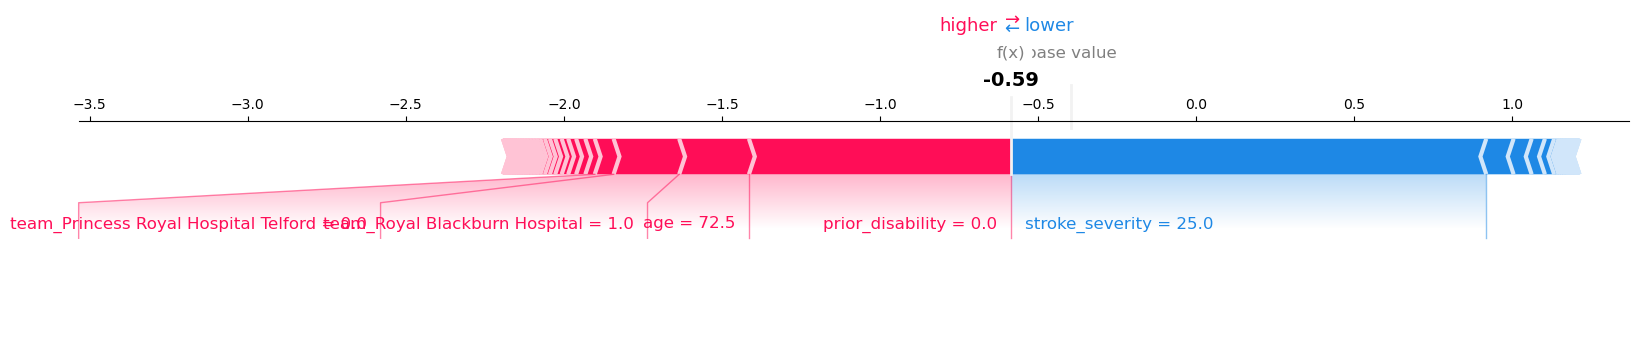

In [41]:
shap.plots.force(shap_values_extended.base_values[instance,c], 
                 shap_values=shap_values[instance,:,c], 
                 features=X_test.iloc[instance],
                 feature_names=feature_names_ohe, 
                 matplotlib=True)


SHAP waterfall plot

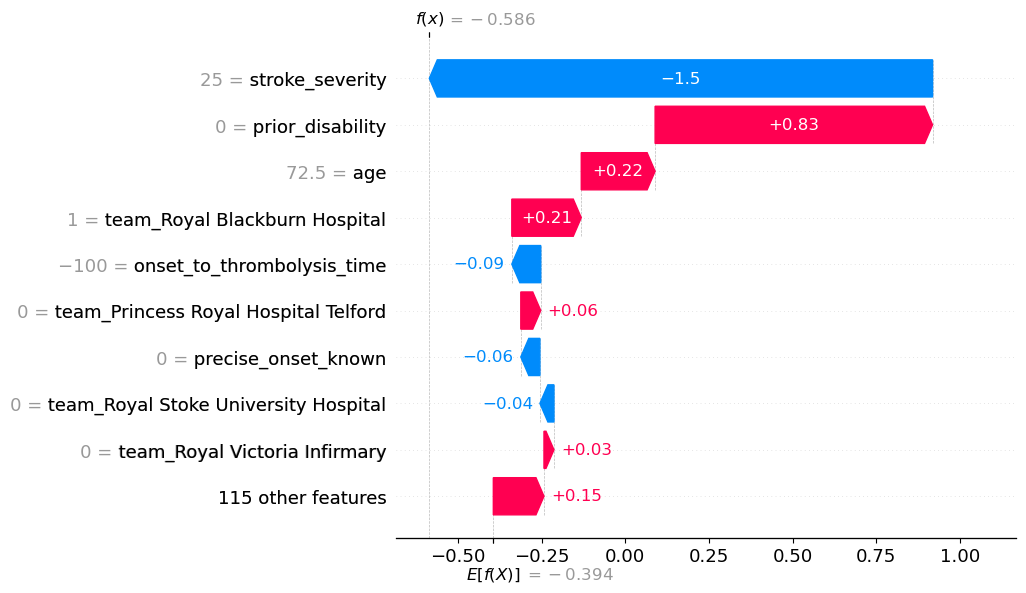

In [42]:
shap.waterfall_plot(shap.Explanation(values=shap_values[instance,:,c], 
                                     base_values=shap_values_extended.base_values[instance,c], 
                                     data=X_test.iloc[instance],  
                                     feature_names=X_test.columns.tolist()))

Let's view these plots for all of the outcome classes for a single instance.

Tried to create a function to create a set of force plots - subplots do not appear to be possible with force plots. Instead create and show each individual force plot.

In [43]:
def create_forceplot_multiclass_grid(
                row, n_classes, k, y_data_row, shap_values_list_row,
                list_base_values, X_data_row, feature_names, pred_mrs_row):
    """
    Each figure showing the relationship between each combination of features 
    on the SHAP value.
    Subplots do not seem to be possible with force plots.

    Args:
        row [integer]: the instance
        n_classes [list]: Class names
        k [integer]: kfold
        y_data_row [string]: the observed class
        shap_values_list_row [list]: shap values
        list_base_values [list]: base values
        X_data_row [series]: feature values for instance
        feature_names [list]: feature names
        pred_mrs_row [string]: the predicted class

    Return:
        None
    """

    # Each figure showing the relationship between
    # each combination of features on the SHAP value.
    # Subplots do not seem to be possible with force plots.

    for c in range(n_classes):
        shap.plots.force(list_base_values[c],
                        shap_values=shap_values_list_row[c],
                        features=X_data_row,
                        feature_names=feature_names, 
                        matplotlib=True,
                        show=False)#,

        title = (f"Predicting discharge mRS {c}.\n\nForce plot for instance "
                 f"{row}, for k-fold {k} (observed discharge mRS: {y_data_row},"
                 f" predicted discharge mRS: {pred_mrs_row}.\n")

        plt.title(title, y=1.75, pad=-50)
        
        plt.gcf().set_size_inches(20,6)
        plt.tight_layout()
        filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         f'_forceplot_for_class_{c}.jpg'))
        plt.savefig(filename, dpi=300)

        plt.show()

    return()

View force plots for all classes for a single instance (for a single k-fold). The class with the highest probability, is the resulting classification for this instance from the model.

(Can not look at a specific instance across the kfolds, as an instance is only in the test set for one kfold).

In [ ]:
# Initialise empty list
list_shap_values = []
list_base_values = []

# Putting the SHAP values in the required format
for c in range(n_classes):
    list_shap_values.append(shap_values[instance,:,c])
    list_base_values.append(shap_values_extended.base_values[instance,c])

# Call funciton to create subplots
create_forceplot_multiclass_grid(instance, n_classes, k,
                                 y_test.iloc[instance], 
                                 list_shap_values,
                                 list_base_values, 
                                 X_test.iloc[instance], 
                                 feature_names_ohe, y_pred[instance])

Function to create a set of waterfall plots

In [44]:
def create_waterfall_multiclass_grid(
                row, n_classes, k, y_data_row, shap_values_list_row,
                list_base_values, X_data_row, feature_names, pred_mrs_row):
    """
    Create a matrix of subplots per class. Each showing the relationship between
    each combination of features on the SHAP value.
    Setup matrix of subplots
    
    Args:
        row [integer]: the instance
        n_classes [list]: Class names
        k [integer]: kfold
        y_data_row [string]: the observed class
        shap_values_list_row [list]: shap values
        list_base_values [list]: base values
        X_data_row [series]: feature values for instance
        feature_names [list]: feature names
        pred_mrs_row [string]: the predicted class

    Return:
        None
    """
    # Create a matrix of subplots per class. Each showing the relationship between
    # each combination of features on the SHAP value.
    # setup matrix of subplots
    fig = plt.figure()

    # Set overall title
    fig.suptitle(f'Waterfall for instance {row}.\n'
                 f'Observed discharge mRS: {y_data_row}, '
                 f'predicted discharge mRS: {pred_mrs_row}.\n'
                 f'(a subplot for each mRS class, for k-fold {k})',
                fontsize=20)

    for c in range(n_classes):
        ax = fig.add_subplot(4,2,c+1)
        shap.waterfall_plot(shap.Explanation(values=shap_values_list_row[c], 
                                            base_values=list_base_values[c], 
                                            data=X_data_row,  
                                            feature_names=feature_names), 
                                            show=False)
        ax.set_title(f"Predicting discharge mRS {c}")
        
    plt.gcf().set_size_inches(20,15)
    plt.tight_layout()

    filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_waterfall_for_each_class.jpg'))
    plt.savefig(filename, dpi=300)

    plt.show()

    return()
    

View waterfall plots for all classes for a single instance (for a single k-fold). The class with the highest probability, is the resulting classification for this instance from the model.

(Can not look at a specific instance across the kfolds, as an instance is only in the test set for one kfold).

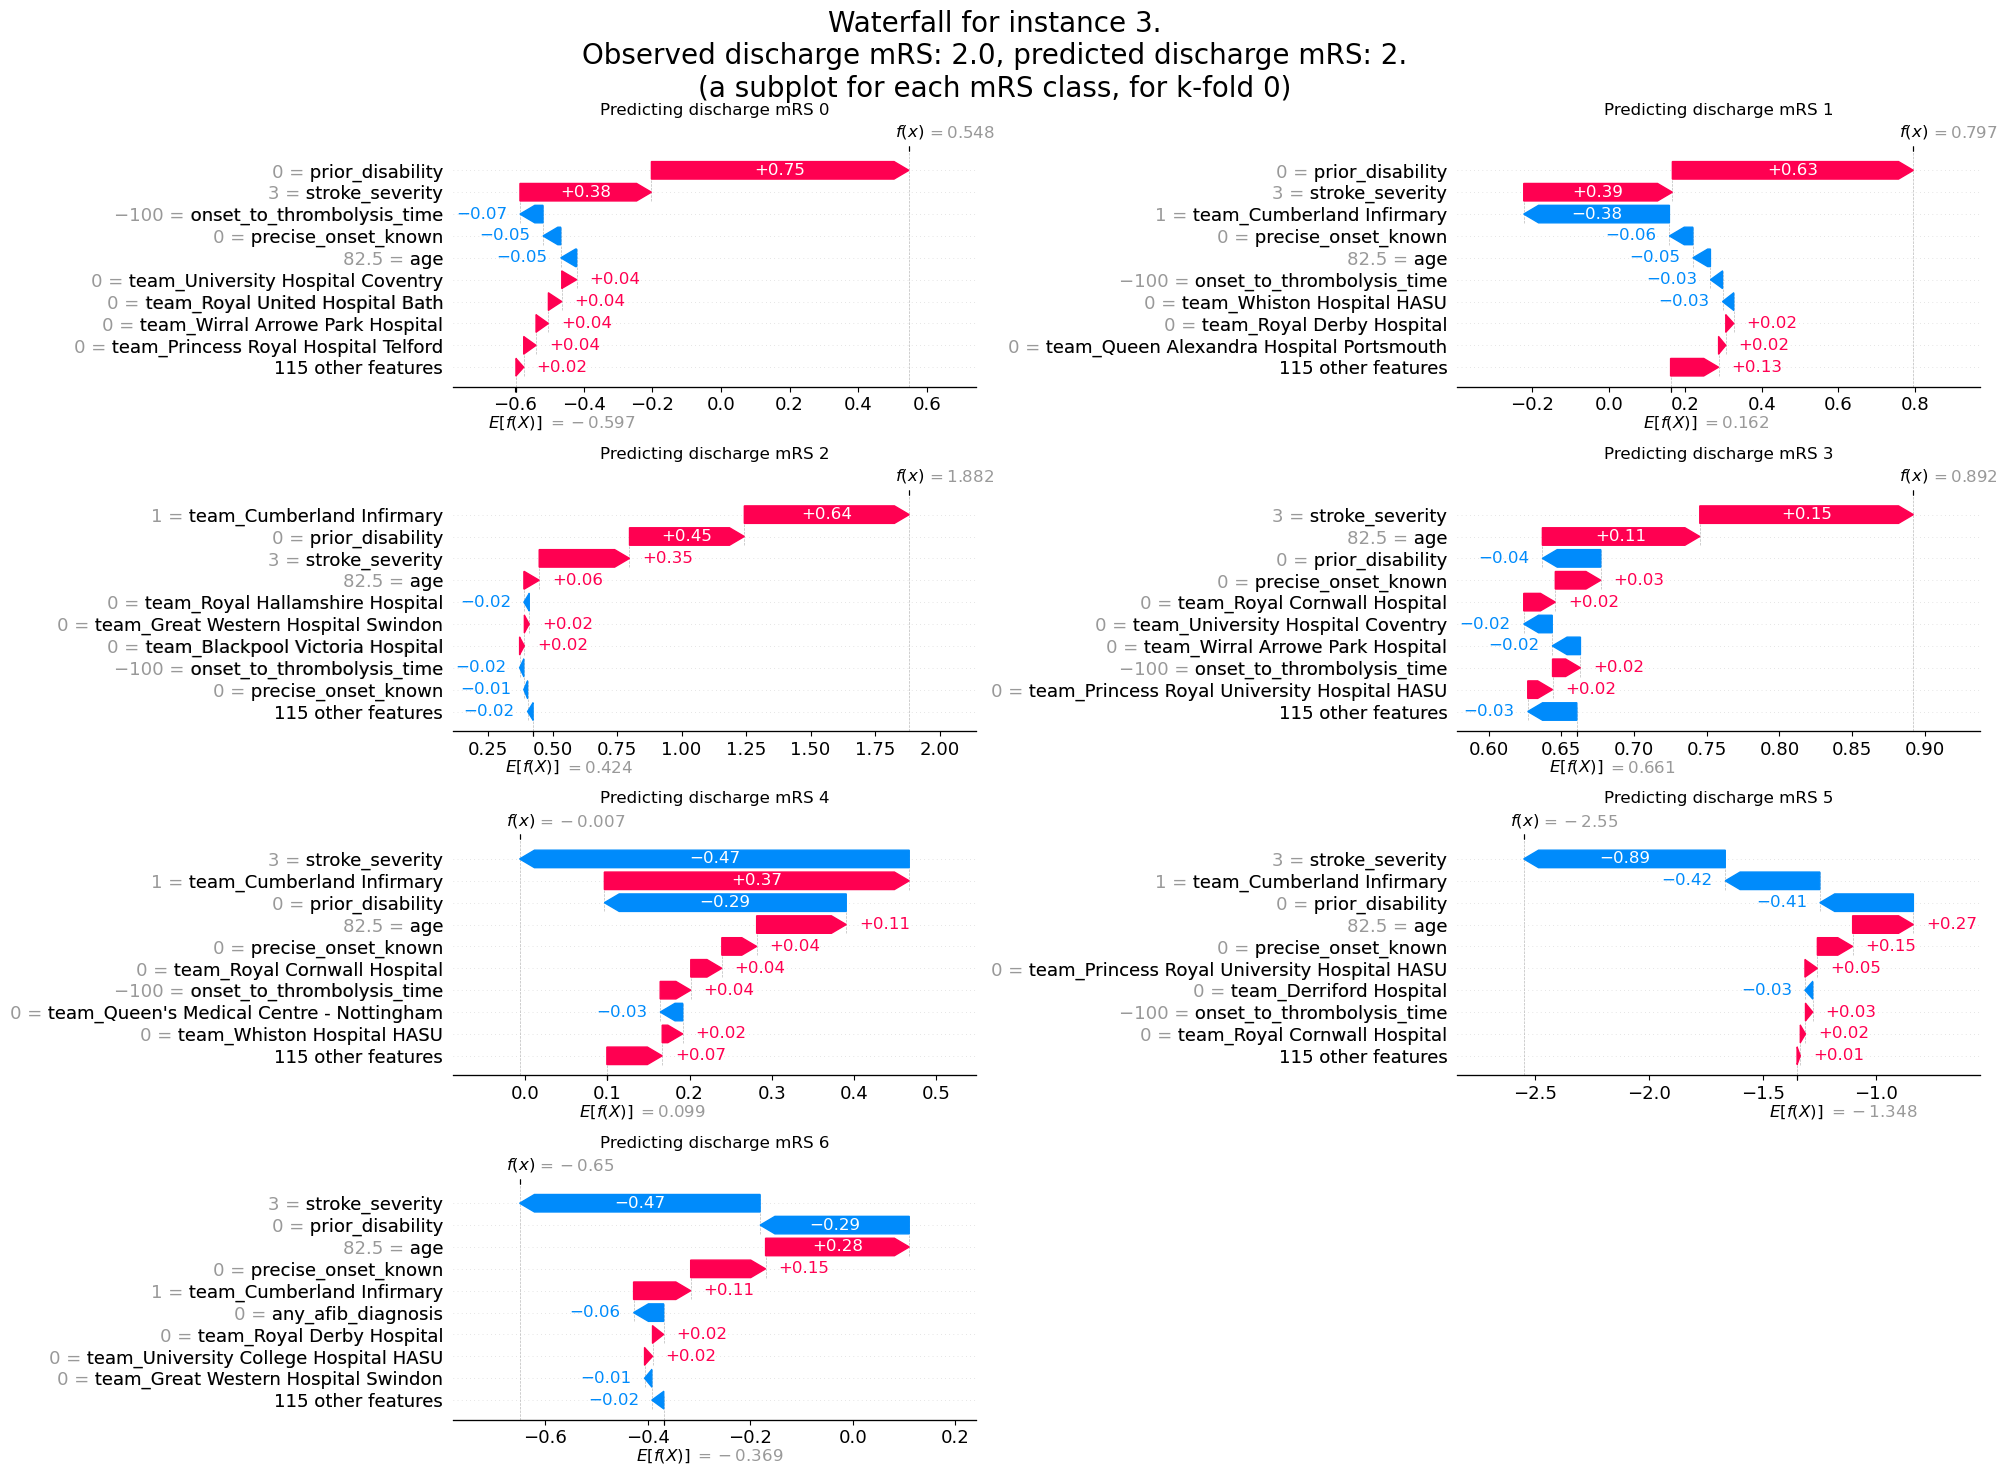

()

In [46]:
# Initialise empty list
list_shap_values = []
list_base_values = []

# Putting the SHAP values in the required format
for c in range(n_classes):
    list_shap_values.append(shap_values[instance,:,c])
    list_base_values.append(shap_values_extended.base_values[instance,c])

# Call funciton to create subplots
create_waterfall_multiclass_grid(instance, n_classes, k,
                                 y_test.iloc[instance], 
                                 list_shap_values,
                                 list_base_values, X_test.iloc[instance], 
                                 feature_names_ohe, y_pred[instance])

Duration to run notebook

In [ ]:

str(datetime.timedelta(seconds=(time.time()-start_time)))